In [1]:
from ibmm import EyeClassifier
# from ibmm_online import EyeClassifierOnline
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from matplotlib import cm

from parser_utils import read_periph_recording, parse_new_dreyevr_rec, GetGazeDeviationFromHead
from pathlib import Path
from tqdm import tqdm
import pickle as pkl

In [2]:
%matplotlib ipympl
%load_ext autoreload
%autoreload 2

In [3]:
import sys
sys.path.append(".\\dreyevr_parser")

In [4]:
from dreyevr_parser.parser import parse_file
from typing import Dict, List, Any
from utils import (
    check_for_periph_data,
    convert_to_df,
    split_along_subgroup,
    get_good_idxs,
)
from visualizer import plot_versus

In [5]:

path_to_recording = "rect_task_eyehead.txt"
# path_to_recording = "rect_task_eyeonly.txt"
# path_to_recording = "esther55.txt"
# path_to_recording = "C://carla//carla.periph//RecordingTxts//jacob/jacob55.txt"
# path_to_recording = "C://carla//carla.periph//RecordingTxts//george//george-55.txt"

recording_name = Path(path_to_recording).stem
recdf_pklname = Path("temp_data").joinpath(recording_name+".pkl")

# try:
#     df1 = pd.read_pickle(recdf_pklname)
# except FileNotFoundError:
#     df1 = read_periph_recording(path_to_recording)
#     df1.to_pickle(recdf_pklname)
# df1 = df1.convert_dtypes()

In [6]:
data: Dict[str, np.ndarray or dict] = parse_file(path_to_recording)

"""append/generate periph data if available"""
print(data)
# check for periph data
PeriphData = check_for_periph_data(data)
if PeriphData is not None:
    data["PeriphData"] = PeriphData

"""convert to pandas df"""
# need to split along groups so all data lengths are the same
data_groups = split_along_subgroup(data, ["CustomActor"])
data_groups_df: List[pd.DataFrame] = [convert_to_df(x) for x in data_groups]
df_new = data_groups_df[0]

Loaded data from /Users/georgejcyu/Desktop/Research/dreyevr_recording_analyzer-main/dreyevr_parser/cache/rect_task_eyehead.pkl
{'TimeElapsed': array([0.00000e+00, 1.98816e-02, 4.44214e-02, ..., 3.30185e+01,
       3.33518e+01, 3.36852e+01]), 'TimestampCarla': array([313619, 313639, 313663, ..., 346637, 346970, 347304]), 'EyeTracker': {'TimestampDevice': array([4217956, 4217973, 4218015, ..., 4250974, 4251316, 4251641]), 'FrameSequence': array([96350973, 96350975, 96350980, ..., 96354936, 96354977, 96355016]), 'COMBINEDGazeDir': array([[ 1.   ,  0.   ,  0.   ],
       [ 1.   ,  0.003, -0.001],
       [ 1.   ,  0.005, -0.001],
       ...,
       [ 1.   , -0.001,  0.003],
       [ 1.   ,  0.   ,  0.002],
       [ 1.   , -0.004, -0.027]]), 'COMBINEDGazeOrigin': array([[-2.676,  0.279, -0.02 ],
       [-2.717,  0.28 , -0.01 ],
       [-2.719,  0.279, -0.009],
       ...,
       [-2.657,  0.279, -0.017],
       [-2.693,  0.281, -0.005],
       [-2.717,  0.277,  0.019]]), 'COMBINEDGazeValid':

In [7]:
df = parse_new_dreyevr_rec(path_to_recording, False)
df1 = df.copy()

100%|██████████| 1474/1474 [00:10<00:00, 145.95it/s]


In [8]:
df.tail()
df.loc[:,"GazeDir_RIGHT"].to_numpy()
df.loc[1231]

TimeElapsed                                            27.3341
TimestampCarla                                          340953
TimestampDevice                                        4245284
FrameSequence                                         96354253
GazeDir_COMBINED                       [0.875, -0.419, -0.242]
GazeOrigin_COMBINED                    [-2.695, 0.503, -0.123]
GazeValid_COMBINED                                           1
GazeVergence_COMBINED                                 113.9897
GazeDir_LEFT                           [0.867, -0.429, -0.254]
GazeOrigin_LEFT                           [-2.8, 3.759, 0.085]
GazeValid_LEFT                                               1
EyeOpenness_LEFT                                        0.7052
EyeOpennessValid_LEFT                                        1
PupilDiameter_LEFT                                      3.5339
PupilPosition_LEFT                            [-0.442, -0.169]
PupilPositionValid_LEFT                                

In [9]:
from ibmm import EyeClassifier
from ibmm_online import EyeClassifierOnline
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import glob
import cv2
import os
from matplotlib import cm
from PIL import Image
from pathlib import Path
from matplotlib import animation
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
%matplotlib notebook

In [38]:
# LLines = []
# with open("LGaze.txt","r") as f:
#     LLines = f.readlines()
    
# RLines = []
# with open("RGaze.txt","r") as f:
#     RLines = f.readlines()
    
# GLines = []
# with open("Gaze.txt","r") as f:
#     GLines = f.readlines()

# LGaze = np.zeros((len(LLines), 5))
# for i, line in enumerate(LLines):
#     for j in range(5):
#         LGaze[i,j] = line.split(" ")[j]
        
# RGaze = np.zeros((len(RLines), 5))
# for i, line in enumerate(RLines):
#     for j in range(5):
#         RGaze[i,j] = line.split(" ")[j]
    
# Gaze = np.zeros((len(GLines), 6))
# for i, line in enumerate(GLines):
#     for j in range(6):
#         Gaze[i,j] = line.split(" ")[j]
        
# lines = []
# with open("fullrun.txt") as f:
#     lines = f.readlines()


In [10]:
LGaze = np.zeros((len(df),5))
RGaze = np.zeros((len(df),5))
Gaze = np.zeros((len(df),6))

for i in range(len(df)):
    LGaze[i,0] = df.loc[:,"TimeElapsed"].to_numpy()[i]
    LGaze[i,1] = 1
    LGaze[i,2] = df.loc[:,"GazeDir_LEFT"].to_numpy()[i][0]
    LGaze[i,3] = df.loc[:,"GazeDir_LEFT"].to_numpy()[i][1]
    LGaze[i,4] = df.loc[:,"GazeDir_LEFT"].to_numpy()[i][2]
    
    RGaze[i,0] = df.loc[:,"TimeElapsed"].to_numpy()[i]
    RGaze[i,1] = 1
    RGaze[i,2] = df.loc[:,"GazeDir_RIGHT"].to_numpy()[i][0]
    RGaze[i,3] = df.loc[:,"GazeDir_RIGHT"].to_numpy()[i][1]
    RGaze[i,4] = df.loc[:,"GazeDir_RIGHT"].to_numpy()[i][2]
    
    Gaze[i,0] = df.loc[:,"TimeElapsed"].to_numpy()[i]
    Gaze[i,1] = 1
    Gaze[i,2] = df.loc[:,"GazeDir_COMBINED"].to_numpy()[i][0]
    Gaze[i,3] = df.loc[:,"GazeDir_COMBINED"].to_numpy()[i][1]
    Gaze[i,4] = df.loc[:,"GazeDir_COMBINED"].to_numpy()[i][2]

print(LGaze)
print(RGaze)
print(Gaze)

[[ 0.00000e+00  1.00000e+00  1.00000e+00 -1.00000e-02 -0.00000e+00]
 [ 1.98816e-02  1.00000e+00  1.00000e+00 -9.00000e-03  1.00000e-03]
 [ 4.44214e-02  1.00000e+00  1.00000e+00 -9.00000e-03  0.00000e+00]
 ...
 [ 3.26836e+01  1.00000e+00  1.00000e+00  2.00000e-03 -1.00000e-03]
 [ 3.30185e+01  1.00000e+00  1.00000e+00 -1.10000e-02 -1.00000e-03]
 [ 3.33518e+01  1.00000e+00  1.00000e+00 -1.00000e-02  1.00000e-03]]
[[ 0.00000e+00  1.00000e+00  1.00000e+00  1.10000e-02  1.00000e-03]
 [ 1.98816e-02  1.00000e+00  1.00000e+00  1.60000e-02 -3.00000e-03]
 [ 4.44214e-02  1.00000e+00  1.00000e+00  2.00000e-02 -2.00000e-03]
 ...
 [ 3.26836e+01  1.00000e+00  1.00000e+00  1.50000e-02  2.20000e-02]
 [ 3.30185e+01  1.00000e+00  1.00000e+00  1.00000e-02  8.00000e-03]
 [ 3.33518e+01  1.00000e+00  1.00000e+00  1.10000e-02  3.00000e-03]]
[[ 0.00000e+00  1.00000e+00  1.00000e+00  0.00000e+00  0.00000e+00
   0.00000e+00]
 [ 1.98816e-02  1.00000e+00  1.00000e+00  3.00000e-03 -1.00000e-03
   0.00000e+00]
 [ 4.4

In [11]:
def GetGazeDeviationFromHead(gaze_x, gaze_y, gaze_z):
    # generates pitch and yaw angles of gaze ray from head direction
    # head direction is (1,0,0)
    yaw = np.arctan2(gaze_y, gaze_x)
    pitch = np.arctan2(gaze_z, gaze_x)
    
    return yaw*180/np.pi, pitch*180/np.pi

In [12]:
# Compute pitch and yaws for Gaze
gaze_pitches = np.zeros(len(Gaze))
gaze_yaws = np.zeros(len(Gaze))

for i, gaze in enumerate(Gaze):
    gaze_x = gaze[2]
    gaze_y = gaze[3]
    gaze_z = gaze[4]
    gaze_yaws[i], gaze_pitches[i] = GetGazeDeviationFromHead(gaze_x, gaze_y, gaze_z)

# gaze_pitches.min()
# gaze_yaws.max()
gaze_yaws.min()

-31.802970168019762

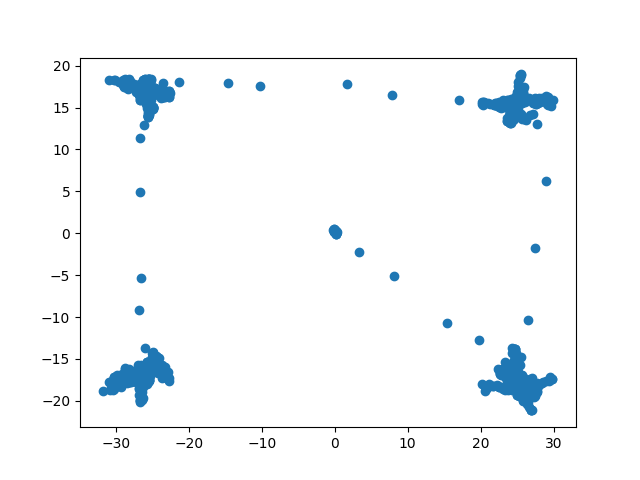

In [13]:
plt.figure()
# plt.scatter(gaze_yaws[500:-500], gaze_pitches[500:-500])
start_frame = 30
end_frame = 200
plt.scatter(gaze_yaws[start_frame:-end_frame], gaze_pitches[start_frame:-end_frame])

In [14]:
for i, gaze in enumerate(Gaze):
    if gaze_pitches[i] == 0 and gaze_yaws[i] == 0:
        # set confidence value
        gaze[1] = 0.2

In [15]:
pdGaze = pd.DataFrame(Gaze, columns = ['timestamp','confidence','x','y','z','lightOn'])
print(pdGaze)

      timestamp  confidence    x      y      z  lightOn
0      0.000000         0.2  1.0  0.000  0.000      0.0
1      0.019882         1.0  1.0  0.003 -0.001      0.0
2      0.044421         1.0  1.0  0.005 -0.001      0.0
3      0.083633         1.0  1.0  0.005 -0.001      0.0
4      0.099590         1.0  1.0  0.005 -0.001      0.0
...         ...         ...  ...    ...    ...      ...
1469  32.639900         1.0  1.0 -0.005  0.003      0.0
1470  32.663900         1.0  1.0 -0.002  0.003      0.0
1471  32.683600         1.0  1.0  0.009  0.011      0.0
1472  33.018500         1.0  1.0 -0.001  0.003      0.0
1473  33.351800         1.0  1.0  0.000  0.002      0.0

[1474 rows x 6 columns]


In [16]:
# Get Head Data and World Data

# Create the new pd
gaze_only = np.copy(Gaze)
gaze_head = np.copy(Gaze)
gaze_world = np.copy(Gaze)

head_pitch = np.zeros(len(df))
head_yaw = np.zeros(len(df))
world_pitch = np.zeros(len(df))
world_yaw = np.zeros(len(df))

for i in range(len(df)):
    head_pitch[i] = df.loc[:,"CameraRot"].to_numpy()[i][0]
    head_yaw[i] = df.loc[:,"CameraRot"].to_numpy()[i][2]
    world_pitch[i] = df.loc[:,"VehicleRot"].to_numpy()[i][0]
    world_yaw[i] = df.loc[:,"VehicleRot"].to_numpy()[i][2]

gaze_head_pitch = gaze_pitches + head_pitch
gaze_head_yaw = gaze_yaws + head_yaw

gaze_world_pitch = gaze_pitches + world_pitch
gaze_world_yaw = gaze_yaws + world_yaw

gaze_only[:,2] = gaze_pitches
gaze_only[:,3] = gaze_yaws
gaze_only[:,4] = np.zeros(len(Gaze))
pdGazeOnly = pd.DataFrame(gaze_only, columns = ['timestamp','confidence','x','y','z','lightOn'])
print(pdGazeOnly)

gaze_head[:,2] = gaze_head_pitch
gaze_head[:,3] = gaze_head_yaw
gaze_head[:,4] = np.zeros(len(Gaze))
pdGazeHead = pd.DataFrame(gaze_head, columns = ['timestamp','confidence','x','y','z','lightOn'])
print(pdGazeHead)

gaze_world[:,2] = gaze_world_pitch
gaze_world[:,3] = gaze_world_yaw
gaze_world[:,4] = np.zeros(len(Gaze))
pdGazeWorld = pd.DataFrame(gaze_world, columns = ['timestamp','confidence','x','y','z','lightOn'])


      timestamp  confidence         x         y    z  lightOn
0      0.000000         0.2  0.000000  0.000000  0.0      0.0
1      0.019882         1.0 -0.057296  0.171887  0.0      0.0
2      0.044421         1.0 -0.057296  0.286477  0.0      0.0
3      0.083633         1.0 -0.057296  0.286477  0.0      0.0
4      0.099590         1.0 -0.057296  0.286477  0.0      0.0
...         ...         ...       ...       ...  ...      ...
1469  32.639900         1.0  0.171887 -0.286477  0.0      0.0
1470  32.663900         1.0  0.171887 -0.114591  0.0      0.0
1471  32.683600         1.0  0.630228  0.515648  0.0      0.0
1472  33.018500         1.0  0.171887 -0.057296  0.0      0.0
1473  33.351800         1.0  0.114591  0.000000  0.0      0.0

[1474 rows x 6 columns]
      timestamp  confidence         x         y    z  lightOn
0      0.000000         0.2 -4.904328 -0.433635  0.0      0.0
1      0.019882         1.0 -4.979150 -0.241913  0.0      0.0
2      0.044421         1.0 -4.979342 -0.1211

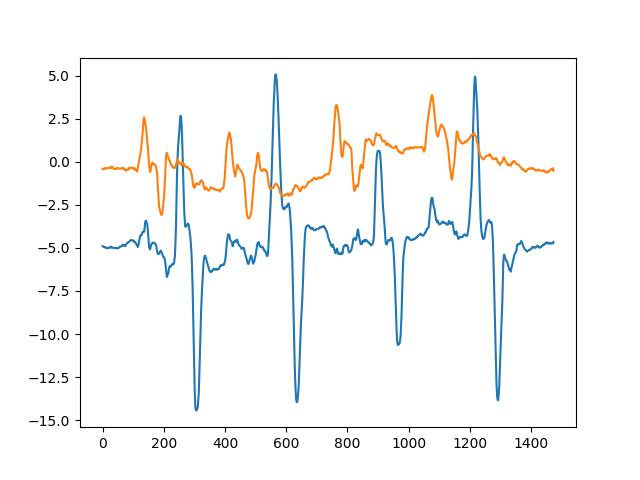

In [17]:
plt.figure()
plt.plot(head_pitch)
plt.plot(head_yaw)

In [18]:
# # Generate different fixation classifications
# # gaze+head
# head_data = []
# for i, line in enumerate(lines):
#     if "pitch" in line:
#         head_data.append(lines[i])
        
# head_pitch = np.zeros(len(head_data))
# head_yaw = np.zeros(len(head_data))

# for i, line in enumerate(head_data):
#     HMDRot = re.findall(r"HMDRot: \{[-]?\d+[.]?\d*[e]?[-]?\d*,[-]?\d+[.]?\d*[e]?[-]?\d*,[-]?\d+[.]?\d*[e]?[-]?\d*\}",line)
#     HMDRot_vals = re.findall(r"[-]?\d+[.]?\d*[e]?[-]?\d*", HMDRot[0])
#     head_pitch[i] = float(HMDRot_vals[0])
#     head_yaw[i] = float(HMDRot_vals[2])
    
# head_pitch = head_pitch[:-1]
# head_yaw = head_yaw[:-1]
# gaze_head_pitch = gaze_pitches + head_pitch
# gaze_head_yaw = gaze_yaws + head_yaw

# # gaze+world
# world_data = []
# for i, line in enumerate(lines):
#     if "pitch" in line:
#         world_data.append(lines[i])
        
# world_pitch = np.zeros(len(world_data))
# world_yaw = np.zeros(len(world_data))

# for i, line in enumerate(world_data):
#     WorldRot = re.findall(r"WorldRot: \{[-]?\d+[.]?\d*[e]?[-]?\d*,[-]?\d+[.]?\d*[e]?[-]?\d*,[-]?\d+[.]?\d*[e]?[-]?\d*\}",line)
#     WorldRot_vals = re.findall(r"[-]?\d+[.]?\d*[e]?[-]?\d*", WorldRot[0])
#     world_pitch[i] = float(WorldRot_vals[0])
#     world_yaw[i] = float(WorldRot_vals[2])
    
# world_pitch = world_pitch[:-1]
# world_yaw = world_yaw[:-1]
# gaze_world_pitch = gaze_pitches + world_pitch
# gaze_world_yaw = gaze_yaws + world_yaw


# # Create the new pd
# gaze_only = np.copy(Gaze)
# gaze_head = np.copy(Gaze)
# gaze_world = np.copy(Gaze)

# gaze_only[:,2] = gaze_pitches
# gaze_only[:,3] = gaze_yaws
# gaze_only[:,4] = np.zeros(len(Gaze))
# pdGazeOnly = pd.DataFrame(gaze_only, columns = ['timestamp','confidence','x','y','z','lightOn'])
# print(pdGazeOnly)

# gaze_head[:,2] = gaze_head_pitch
# gaze_head[:,3] = gaze_head_yaw
# gaze_head[:,4] = np.zeros(len(Gaze))
# pdGazeHead = pd.DataFrame(gaze_head, columns = ['timestamp','confidence','x','y','z','lightOn'])
# print(pdGazeHead)

# gaze_world[:,2] = gaze_world_pitch
# gaze_world[:,3] = gaze_world_yaw
# gaze_world[:,4] = np.zeros(len(Gaze))
# pdGazeWorld = pd.DataFrame(gaze_world, columns = ['timestamp','confidence','x','y','z','lightOn'])

In [19]:
# world-based
# gaze_data = pdGazeOnly.iloc[1200:1300]
gaze_data = pdGazeOnly
#print(len(gaze_pitches))

#gaze_data.reset_index(drop = True,inplace = True)
# print("gaze_data: ",gaze_data)

vel_w = EyeClassifier.preprocess(gaze_data, dist_method='euclidean')
model = EyeClassifier()
model.fit(world=vel_w)

raw_vel = vel_w[np.logical_not(vel_w.velocity.isna())].velocity.values
raw_vel[raw_vel > raw_vel.mean() + 3 * raw_vel.std()]
print("Velocity Means: ",model.world_model.means_)

# Set velocity model means
#model.world_model.means_[0] = 0
#model.world_model.means_[1] = 0.01
# print("New Velocity Means: ",model.world_model.means_)

# Display velocity means
# plt.figure()
# plt.hist(raw_vel, bins=1000)
# plt.vlines(model.world_model.means_, ymin=0, ymax=50, colors="r")
# plt.xlabel("velocity")
# plt.ylabel("# points")
# #plt.xlim(0,model.world_model.means_[1]+0.01)
# plt.show()


# compute the fixation and saccade mean velocities
# then we change the model so that it classifies more saccades
# and replot the fixation and saccade mean velocities

fix, fix_gaze_seqs = model.get_fixations(world=vel_w, gaze_data=gaze_data)
sac, sac_gaze_seqs = model.get_saccades(world=vel_w, gaze_data=gaze_data, min_sac_dur=None)
short_fix, short_fix_gaze_seqs = model.get_short_fixations(world=vel_w, gaze_data=gaze_data)
#print(fix)


ts = gaze_data.timestamp.values
labels, _ = model.predict(world=vel_w, ts=ts)

fix_label_count = 0

for seq_df in fix_gaze_seqs:
    start = seq_df.index[0]
    end = seq_df.index[-1]
    N = end - start + 1
    seq_df.insert(4, "pitch", gaze_pitches[start:end+1], True)
    seq_df.insert(5, "yaw", gaze_yaws[start:end+1], True)
    seq_df.insert(6, "label", np.full(N, fix_label_count), True)
    seq_df.insert(7, "head_pitch", head_pitch[start:end+1], True)
    seq_df.insert(8, "head_yaw", head_yaw[start:end+1], True)
    fix_label_count += 1
    
sac_label_count = 0

for seq_df in sac_gaze_seqs:
    start = seq_df.index[0]
    end = seq_df.index[-1]
    N = end - start + 1
    seq_df.insert(4, "pitch", gaze_pitches[start:end+1], True)
    seq_df.insert(5, "yaw", gaze_yaws[start:end+1], True)
    seq_df.insert(6, "label", np.full(N, 100), True)
    seq_df.insert(7, "head_pitch", head_pitch[start:end+1], True)
    seq_df.insert(8, "head_yaw", head_yaw[start:end+1], True)
    sac_label_count += 1
    
short_fix_label_count = 0

for seq_df in short_fix_gaze_seqs:
    start = seq_df.index[0]
    end = seq_df.index[-1]
    N = end - start + 1
    seq_df.insert(4, "pitch", gaze_pitches[start:end+1], True)
    seq_df.insert(5, "yaw", gaze_yaws[start:end+1], True)
    seq_df.insert(6, "label", np.full(N, 100), True)
    seq_df.insert(7, "head_pitch", head_pitch[start:end+1], True)
    seq_df.insert(8, "head_yaw", head_yaw[start:end+1], True)
    short_fix_label_count += 1

Velocity Means:  [[ 9.29668708]
 [96.16423947]]
self.world_model.means_ [[ 9.29668708]
 [96.16423947]]
self.world_model.means_ [[ 9.29668708]
 [96.16423947]]
is_sac:  [0 0 0 ... 1 0 0]
sac_change:  [ 0  0  0 ...  1 -1  0]
sac_start:  [  17   21   60   71  138  159  179  184  188  199  202  240  249  253
  262  278  297  299  306  312  341  348  354  392  400  404  409  417
  421  430  471  480  501  506  513  518  529  573  634  644  646  682
  696  735  750  769  771  775  779  781  784  787  818  823  831  834
  840  842  849  867  934  962  976 1006 1024 1072 1083 1089 1101 1110
 1124 1128 1133 1135 1144 1146 1148 1151 1153 1164 1191 1209 1212 1224
 1235 1237 1244 1278 1280 1284 1286 1289 1300 1302 1307 1311 1316 1318
 1331 1344 1354 1423 1432 1471]
sac_end:  [  17   27   64   71  138  159  180  184  190  199  202  240  249  253
  262  278  297  299  307  313  346  348  354  392  401  404  409  417
  421  430  471  480  501  506  513  518  529  573  634  644  646  689
  696  735  75

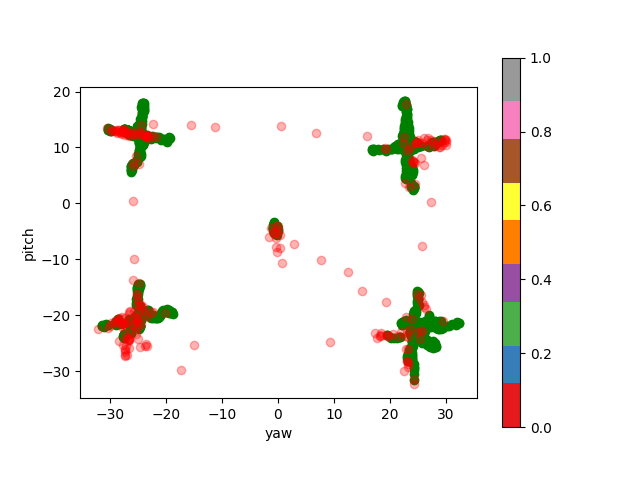

In [20]:
first_label = 0
fix_last_label = fix_label_count-1
sac_last_label = sac_label_count-1
short_fix_last_label = short_fix_label_count-1
if (short_fix_last_label == 0):
    short_fix_last_label = 1
all_last_label = fix_label_count+sac_label_count+short_fix_label_count-1

# all gaze sequences
all_gaze_seqs = fix_gaze_seqs + sac_gaze_seqs + short_fix_gaze_seqs
colormap = cm.get_cmap('Set1', len(fix))
fig, ax = plt.subplots()

total_points = 0

#print(all_gaze_seqs)

for i, seq_df in enumerate(all_gaze_seqs):
    total_points += len(seq_df)
    
    seq = np.array([seq_df.yaw+seq_df.head_yaw, seq_df.pitch+seq_df.head_pitch])
    a = seq_df.label.values
    start_time = seq_df.timestamp.values[0]
    end_time = seq_df.timestamp.values[-1]
    
    if (a[0] == 100):
        if (start_time != end_time):
            time_vals = (seq_df.timestamp.values - start_time) / (end_time - start_time)
            time_vals = time_vals / 2 + 0.5
            cmap_RGBA = colormap(a[0]/fix_last_label)
            cmap_RGBA = np.asarray([(cmap_RGBA[0], cmap_RGBA[1], cmap_RGBA[2], a) for a in time_vals])
        else:
            cmap_RGBA = colormap(a[0]/fix_last_label)
        ax.scatter(seq[0], seq[1], color="r", alpha=0.3)
    else:
        if (start_time != end_time):
            time_vals = (seq_df.timestamp.values - start_time) / (end_time - start_time)
            time_vals = time_vals / 2 + 0.5
            cmap_RGBA = colormap(a[0]/fix_last_label)
            cmap_RGBA = np.asarray([(cmap_RGBA[0], cmap_RGBA[1], cmap_RGBA[2], a) for a in time_vals])
        else:
            cmap_RGBA = colormap(a[0]/fix_last_label)
        ax.scatter(seq[0], seq[1], color="g")
    
#print(total_points)
    
fig.colorbar(cm.ScalarMappable(cmap=colormap))
ax.set_aspect('equal')
ax.set_xlabel("yaw")
ax.set_ylabel("pitch")
plt.show()

In [21]:
# head-based
# gaze_data = pdGazeOnly.iloc[1200:1300]
gaze_data = pdGazeHead

vel_w = EyeClassifier.preprocess(gaze_data, dist_method='euclidean')
model = EyeClassifier()
model.fit(world=vel_w)

raw_vel = vel_w[np.logical_not(vel_w.velocity.isna())].velocity.values
raw_vel[raw_vel > raw_vel.mean() + 3 * raw_vel.std()]

# compute the fixation and saccade mean velocities
# then we change the model so that it classifies more saccades
# and replot the fixation and saccade mean velocities

fix, fix_gaze_seqs = model.get_fixations(world=vel_w, gaze_data=gaze_data)
sac, sac_gaze_seqs = model.get_saccades(world=vel_w, gaze_data=gaze_data, min_sac_dur=None)
short_fix, short_fix_gaze_seqs = model.get_short_fixations(world=vel_w, gaze_data=gaze_data)

# ts = gaze_data.timestamp.values
labels, _ = model.predict(world=vel_w)

fix_label_count = 0

for seq_df in fix_gaze_seqs:
    start = seq_df.index[0]
    end = seq_df.index[-1]
    N = end - start + 1
    seq_df.insert(4, "pitch", gaze_pitches[start:end+1], True)
    seq_df.insert(5, "yaw", gaze_yaws[start:end+1], True)
    seq_df.insert(6, "label", np.full(N, fix_label_count), True)
    seq_df.insert(7, "head_pitch", head_pitch[start:end+1], True)
    seq_df.insert(8, "head_yaw", head_yaw[start:end+1], True)
    fix_label_count += 1
    
sac_label_count = 0

for seq_df in sac_gaze_seqs:
    start = seq_df.index[0]
    end = seq_df.index[-1]
    N = end - start + 1
    seq_df.insert(4, "pitch", gaze_pitches[start:end+1], True)
    seq_df.insert(5, "yaw", gaze_yaws[start:end+1], True)
    seq_df.insert(6, "label", np.full(N, 100), True)
    seq_df.insert(7, "head_pitch", head_pitch[start:end+1], True)
    seq_df.insert(8, "head_yaw", head_yaw[start:end+1], True)
    sac_label_count += 1
    
short_fix_label_count = 0

for seq_df in short_fix_gaze_seqs:
    start = seq_df.index[0]
    end = seq_df.index[-1]
    N = end - start + 1
    seq_df.insert(4, "pitch", gaze_pitches[start:end+1], True)
    seq_df.insert(5, "yaw", gaze_yaws[start:end+1], True)
    seq_df.insert(6, "label", np.full(N, 100), True)
    seq_df.insert(7, "head_pitch", head_pitch[start:end+1], True)
    seq_df.insert(8, "head_yaw", head_yaw[start:end+1], True)
    short_fix_label_count += 1
    
all_gaze_head_seqs = fix_gaze_seqs + sac_gaze_seqs + short_fix_gaze_seqs

self.world_model.means_ [[ 12.57929392]
 [121.196288  ]]
self.world_model.means_ [[ 12.57929392]
 [121.196288  ]]
is_sac:  [0 0 0 ... 0 0 0]
sac_change:  [0 0 0 ... 0 0 0]
sac_start:  [  21   24   60   71  138  179  184  190  202  205  249  253  278  306
  312  341  354  400  404  409  417  421  471  480  506  513  518  529
  634  683  696  735  771  775  779  782  823  831  842  867  962  976
 1006 1024 1083 1089 1101 1110 1129 1133 1135 1144 1146 1151 1153 1208
 1244 1280 1282 1284 1286 1289 1300 1308 1311 1318 1344 1354 1423 1432]
sac_end:  [  22   27   64   71  138  180  184  190  202  205  249  253  278  307
  312  346  354  401  404  409  417  421  471  480  506  513  518  529
  634  689  696  735  771  775  779  782  823  831  843  867  962  976
 1012 1024 1084 1090 1101 1110 1129 1133 1136 1144 1146 1151 1153 1208
 1245 1280 1282 1284 1286 1289 1300 1309 1311 1318 1347 1357 1423 1432]
self.world_model.means_ [[ 12.57929392]
 [121.196288  ]]
self.world_model.means_ [[ 12.5792939

In [22]:
from itertools import chain
gaze_list = []
gaze_head_list = []

for i, seq in enumerate(all_gaze_seqs):
    gaze_list.append(seq.values.tolist())
    
for i, seq in enumerate(all_gaze_head_seqs):
    gaze_head_list.append(seq.values.tolist())
    
gaze_list = list(chain.from_iterable(gaze_list))
gaze_head_list = list(chain.from_iterable(gaze_head_list))

gaze_arr = np.array(gaze_list)
gaze_sorted = gaze_arr[gaze_arr[:, 0].argsort()]

gaze_head_arr = np.array(gaze_head_list)
gaze_head_sorted = gaze_head_arr[gaze_head_arr[:, 0].argsort()]

print(len(gaze_sorted))
print(len(gaze_head_sorted))
gaze_head_sorted = gaze_head_sorted[:-1]

print(np.count_nonzero(gaze_sorted[:,6] == 100))
print(np.count_nonzero(gaze_head_sorted[:,6] == 100))

1408
1418
246
161


In [23]:
print(labels.iloc[:,3].sum())

110


In [24]:
# gazeOnly Labels (euclidean)
gaze_data = pdGazeOnly
print(pdGazeOnly)
vel_w = EyeClassifier.preprocess(gaze_data, dist_method='euclidean')
model = EyeClassifier()
model.fit(world=vel_w)

ts = gaze_data.timestamp.values
labels, _ = model.predict(world=vel_w, ts=ts)

gazeOnlyEucLabels = labels

# print(labels)
# 0- fix, 1- sac, -1 -> noise
labels_unique = labels
labels_unique.index = np.arange(1, len(labels_unique) + 1) # start index from 1 instead of 0
labels_np = labels_unique.to_numpy()
print("labels_np.shape: ", labels_np.shape)
# add the labels to the original df:
#recdf_with_labels = df2.join(labels_unique["label"])

print("Num fixation total pts: ", np.sum(labels_np[:,2]))
print("Num saccades total pts: ", np.sum(labels_np[:,3]))
print("Num noise total pts: ", np.sum(labels_np[:,4]))
print()
# filter the consecutives
print("Num fixations: ", np.sum(np.diff(labels_np[:, 2]) == 1))
print("Num saccades: ", np.sum(np.diff(labels_np[:, 3]) == 1))
print("Num noise: ", np.sum(np.diff(labels_np[:, 4]) == 1))

      timestamp  confidence         x         y    z  lightOn
0      0.000000         0.2  0.000000  0.000000  0.0      0.0
1      0.019882         1.0 -0.057296  0.171887  0.0      0.0
2      0.044421         1.0 -0.057296  0.286477  0.0      0.0
3      0.083633         1.0 -0.057296  0.286477  0.0      0.0
4      0.099590         1.0 -0.057296  0.286477  0.0      0.0
...         ...         ...       ...       ...  ...      ...
1469  32.639900         1.0  0.171887 -0.286477  0.0      0.0
1470  32.663900         1.0  0.171887 -0.114591  0.0      0.0
1471  32.683600         1.0  0.630228  0.515648  0.0      0.0
1472  33.018500         1.0  0.171887 -0.057296  0.0      0.0
1473  33.351800         1.0  0.114591  0.000000  0.0      0.0

[1474 rows x 6 columns]
self.world_model.means_ [[ 9.29500883]
 [96.12892034]]
labels_np.shape:  (1474, 5)
Num fixation total pts:  1265.0
Num saccades total pts:  162.0
Num noise total pts:  48.0

Num fixations:  106
Num saccades:  105
Num noise:  6


In [24]:
np.allclose(gazeHeadLabels, gazeOnlyLabels)

NameError: name 'gazeHeadLabels' is not defined

In [25]:
# gazeHead Labels (Euclidean)
gaze_data = pdGazeHead
vel_w = EyeClassifier.preprocess(gaze_data, dist_method='euclidean')
model = EyeClassifier()
model.fit(world=vel_w)

ts = gaze_data.timestamp.values
labels, _ = model.predict(world=vel_w, ts=ts)

gazeHeadEucLabels = labels

# 0- fix, 1- sac, -1 -> noise
labels_unique = labels
labels_unique.index = np.arange(1, len(labels_unique) + 1) # start index from 1 instead of 0
labels_np = labels_unique.to_numpy()
print("labels_np.shape: ", labels_np.shape)
# add the labels to the original df:
#recdf_with_labels = df2.join(labels_unique["label"])

print("Num fixation total pts: ", np.sum(labels_np[:,2]))
print("Num saccades total pts: ", np.sum(labels_np[:,3]))
print("Num noise total pts: ", np.sum(labels_np[:,4]))
print()
# filter the consecutives
print("Num fixations: ", np.sum(np.diff(labels_np[:, 2]) == 1))
print("Num saccades: ", np.sum(np.diff(labels_np[:, 3]) == 1))
print("Num noise: ", np.sum(np.diff(labels_np[:, 4]) == 1))

self.world_model.means_ [[ 12.57929392]
 [121.196288  ]]
labels_np.shape:  (1474, 5)
Num fixation total pts:  1317.0
Num saccades total pts:  110.0
Num noise total pts:  48.0

Num fixations:  72
Num saccades:  70
Num noise:  6


In [26]:
gazeOnlyTime = pdGazeOnly.iloc[:,0].to_numpy().reshape(-1,1)
gazeOnlyPitch = pdGazeOnly.iloc[:,2].to_numpy().reshape(-1,1)
gazeOnlyYaw = pdGazeOnly.iloc[:,3].to_numpy().reshape(-1,1)
gazeOnlyEucFix = gazeOnlyEucLabels.iloc[:,2].to_numpy().reshape(-1,1)
print(np.c_[gazeOnlyTime,gazeOnlyPitch,gazeOnlyYaw,gazeOnlyEucFix])

gazeHeadTime = pdGazeHead.iloc[:,0].to_numpy().reshape(-1,1)
gazeHeadPitch = pdGazeHead.iloc[:,2].to_numpy().reshape(-1,1)
gazeHeadYaw = pdGazeHead.iloc[:,3].to_numpy().reshape(-1,1)
gazeHeadEucFix = gazeHeadEucLabels.iloc[:,2].to_numpy().reshape(-1,1)
print(np.c_[gazeHeadTime,gazeHeadPitch,gazeHeadYaw,gazeHeadEucFix])



[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]
 [ 1.98816000e-02 -5.72957604e-02  1.71886823e-01  0.00000000e+00]
 [ 4.44214000e-02 -5.72957604e-02  2.86476510e-01  1.00000000e+00]
 ...
 [ 3.26836000e+01  6.30228156e-01  5.15648093e-01  0.00000000e+00]
 [ 3.30185000e+01  1.71886823e-01 -5.72957604e-02  1.00000000e+00]
 [ 3.33518000e+01  1.14591406e-01  0.00000000e+00  1.00000000e+00]]
[[ 0.00000000e+00 -4.90432800e+00 -4.33635000e-01  1.00000000e+00]
 [ 1.98816000e-02 -4.97914976e+00 -2.41913177e-01  0.00000000e+00]
 [ 4.44214000e-02 -4.97934176e+00 -1.21145490e-01  1.00000000e+00]
 ...
 [ 3.26836000e+01 -4.09808584e+00  1.07314093e-01  1.00000000e+00]
 [ 3.30185000e+01 -4.56241718e+00 -4.37885760e-01  1.00000000e+00]
 [ 3.33518000e+01 -4.53702659e+00 -5.28834000e-01  1.00000000e+00]]


In [27]:
# gazeOnly Labels (vector)
pdGaze = pd.DataFrame(Gaze, columns = ['timestamp','confidence','x','y','z','lightOn'])
gaze_data = pdGaze
print(pdGaze)
vel_w = EyeClassifier.preprocess(gaze_data, dist_method='vector')
model = EyeClassifier()
model.fit(world=vel_w)

ts = gaze_data.timestamp.values
labels, _ = model.predict(world=vel_w, ts=ts)

gazeOnlyVecLabels = labels

# print(labels)
# 0- fix, 1- sac, -1 -> noise
labels_unique = labels
labels_unique.index = np.arange(1, len(labels_unique) + 1) # start index from 1 instead of 0
labels_np = labels_unique.to_numpy()
print("labels_np.shape: ", labels_np.shape)
# add the labels to the original df:
#recdf_with_labels = df2.join(labels_unique["label"])

print("Num fixation total pts: ", np.sum(labels_np[:,2]))
print("Num saccades total pts: ", np.sum(labels_np[:,3]))
print("Num noise total pts: ", np.sum(labels_np[:,4]))
print()
# filter the consecutives
print("Num fixations: ", np.sum(np.diff(labels_np[:, 2]) == 1))
print("Num saccades: ", np.sum(np.diff(labels_np[:, 3]) == 1))
print("Num noise: ", np.sum(np.diff(labels_np[:, 4]) == 1))

      timestamp  confidence    x      y      z  lightOn
0      0.000000         0.2  1.0  0.000  0.000      0.0
1      0.019882         1.0  1.0  0.003 -0.001      0.0
2      0.044421         1.0  1.0  0.005 -0.001      0.0
3      0.083633         1.0  1.0  0.005 -0.001      0.0
4      0.099590         1.0  1.0  0.005 -0.001      0.0
...         ...         ...  ...    ...    ...      ...
1469  32.639900         1.0  1.0 -0.005  0.003      0.0
1470  32.663900         1.0  1.0 -0.002  0.003      0.0
1471  32.683600         1.0  1.0  0.009  0.011      0.0
1472  33.018500         1.0  1.0 -0.001  0.003      0.0
1473  33.351800         1.0  1.0  0.000  0.002      0.0

[1474 rows x 6 columns]
self.world_model.means_ [[0.00089646]
 [0.186688  ]]
labels_np.shape:  (1474, 5)
Num fixation total pts:  1359.0
Num saccades total pts:  68.0
Num noise total pts:  48.0

Num fixations:  39
Num saccades:  37
Num noise:  6


In [28]:
# gazeHead Labels (Vector)
gaze_data = pdGazeHead
vel_w = EyeClassifier.preprocess(gaze_data, dist_method='vector')
model = EyeClassifier()
model.fit(world=vel_w)

ts = gaze_data.timestamp.values
labels, _ = model.predict(world=vel_w, ts=ts)

gazeHeadVecLabels = labels

# 0- fix, 1- sac, -1 -> noise
labels_unique = labels
labels_unique.index = np.arange(1, len(labels_unique) + 1) # start index from 1 instead of 0
labels_np = labels_unique.to_numpy()
print("labels_np.shape: ", labels_np.shape)
# add the labels to the original df:
#recdf_with_labels = df2.join(labels_unique["label"])

print("Num fixation total pts: ", np.sum(labels_np[:,2]))
print("Num saccades total pts: ", np.sum(labels_np[:,3]))
print("Num noise total pts: ", np.sum(labels_np[:,4]))
print()
# filter the consecutives
print("Num fixations: ", np.sum(np.diff(labels_np[:, 2]) == 1))
print("Num saccades: ", np.sum(np.diff(labels_np[:, 3]) == 1))
print("Num noise: ", np.sum(np.diff(labels_np[:, 4]) == 1))

self.world_model.means_ [[0.0032965]
 [1.8506846]]
labels_np.shape:  (1474, 5)
Num fixation total pts:  1384.0
Num saccades total pts:  43.0
Num noise total pts:  48.0

Num fixations:  24
Num saccades:  20
Num noise:  6


In [29]:
gazeOnlyVecFix = gazeOnlyVecLabels.iloc[:,2].to_numpy().reshape(-1,1)
gazeHeadVecFix = gazeHeadVecLabels.iloc[:,2].to_numpy().reshape(-1,1)

In [30]:
# label_difference = (gazeOnlyLabel - gazeHeadLabel != 0)
# print(label_difference)
# plt.figure()
# plt.plot(label_difference)

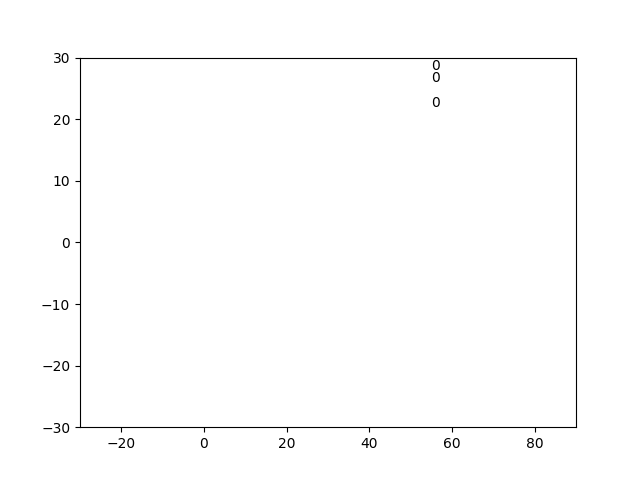

In [31]:
import matplotlib.pyplot as plt
import matplotlib.animation
import numpy as np
from collections import deque

start_frame = 500
end_frame = 540

pitch = gaze_sorted[:,4] 
yaw = gaze_sorted[:,5] 

pitch = pitch[start_frame:end_frame]
yaw = yaw[start_frame:end_frame]

gh_pitch = gaze_head_sorted[:,4] + gaze_head_sorted[:,7]
gh_yaw = gaze_head_sorted[:,5] + gaze_head_sorted[:,8]

gh_pitch = gh_pitch[start_frame:end_frame]
gh_yaw = gh_yaw[start_frame:end_frame]

fig, ax = plt.subplots()
x, y = deque([]),deque([])
ghx, ghy = deque([]),deque([])
sc = ax.scatter(x,y,s=10)
plt.xlim(-30,90)
plt.ylim(-30,30)
time = ax.annotate(0, xy=(55, 28))
framenum = ax.annotate(0, xy=(55, 26))
labdiff = ax.annotate(0, xy=(55, 22))
color = deque([])
ghcolor = deque([])

def animate(i):
    x.append(yaw[i])
    y.append(pitch[i])
    ghx.append(gh_yaw[i]+60)
    ghy.append(gh_pitch[i]) 
    
    sc.set_offsets(np.r_[np.c_[x,y],np.c_[ghx,ghy]])
    
    if (gaze_sorted[i+start_frame,6] == 100):
        color.append("red")
    else:
        color.append("green")
    
    if (gaze_head_sorted[i+start_frame,6] == 100):
        ghcolor.append("red")
    else:
        ghcolor.append("green")
        
    sc.set_color(np.r_[color,ghcolor])
    
    time.set_text("Time: "+str(gaze_sorted[i+start_frame,0]))
    framenum.set_text("Frame: "+str(i+start_frame))
    if (label_difference.iloc[i+start_frame]):
        labdiff.set_text("gazeOnly:"+str(gazeOnlyLabel.iloc[i+start_frame]))
    else:
        labdiff.set_text("Label Diff:False")
        
    if (len(x) > 6):
        x.popleft()
        y.popleft()
        ghx.popleft()
        ghy.popleft()
        color.popleft()
        ghcolor.popleft()
    
    
        
ani = matplotlib.animation.FuncAnimation(fig, animate, 
                frames=len(pitch), interval=500, repeat=True) 
plt.show()

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/matplotlib/animation.py:889: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you have outputted the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


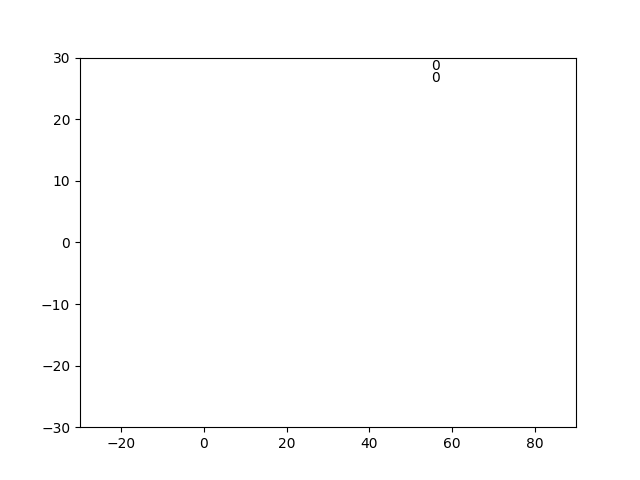

In [32]:
import matplotlib.pyplot as plt
import matplotlib.animation
import numpy as np
from collections import deque

start_frame = 500
end_frame = 540

pitch = gazeOnlyPitch[start_frame:end_frame]
yaw = gazeOnlyYaw[start_frame:end_frame]

gh_pitch = gazeHeadPitch[start_frame:end_frame]
gh_yaw = gazeHeadYaw[start_frame:end_frame]

fig, ax = plt.subplots()
x, y = deque([]),deque([])
ghx, ghy = deque([]),deque([])
sc = ax.scatter(x,y,s=10)
plt.xlim(-30,90)
plt.ylim(-30,30)
time = ax.annotate(0, xy=(55, 28))
framenum = ax.annotate(0, xy=(55, 26))
# labdiff = ax.annotate(0, xy=(55, 22))
color = deque([])
ghcolor = deque([])

def animate(i):
    x.append(yaw[i])
    y.append(pitch[i])
    ghx.append(gh_yaw[i]+60)
    ghy.append(gh_pitch[i]) 
    
    sc.set_offsets(np.r_[np.c_[x,y],np.c_[ghx,ghy]])
    
    if (gazeOnlyFix[i+start_frame] == 0):
        color.append("red")
    else:
        color.append("green")
    
    if (gazeHeadFix[i+start_frame] == 0):
        ghcolor.append("red")
    else:
        ghcolor.append("green")
        
    sc.set_color(np.r_[color,ghcolor])
    
    time.set_text("Time: "+str(gazeOnlyTime[i+start_frame]))
    framenum.set_text("Frame: "+str(i+start_frame))
#     if (label_difference.iloc[i+start_frame]):
#         labdiff.set_text("gazeOnly:"+str(gazeOnlyLabel.iloc[i+start_frame]))
#     else:
#         labdiff.set_text("Label Diff:False")
        
    if (len(x) > 6):
        x.popleft()
        y.popleft()
        ghx.popleft()
        ghy.popleft()
        color.popleft()
        ghcolor.popleft()
    
    
        
ani = matplotlib.animation.FuncAnimation(fig, animate, 
                frames=len(pitch), interval=500, repeat=True) 
plt.show()

In [33]:
pdLGaze = pd.DataFrame(LGaze, columns = ['timestamp','confidence','x','y','z'])
pdRGaze = pd.DataFrame(RGaze, columns = ['timestamp','confidence','x','y','z'])

vel0 = EyeClassifier.preprocess(pdLGaze)
vel1 = EyeClassifier.preprocess(pdRGaze)

model = EyeClassifier()
model.fit(eyes=(vel0, vel1))

labels, indiv_labels = model.predict(eyes=(vel0, vel1))
bothgazeOnlyLabels = labels[1::2]
# print(bothgazeOnlyLabels)
bothgazeOnlyFix = bothgazeOnlyLabels.iloc[:,2].to_numpy().reshape(-1,1)
# print(bothgazeOnlyFix)
# print(sum(bothgazeOnlyFix))

      timestamp  velocity
0      0.000000       NaN
1      0.019882  0.000050
2      0.044421  0.000020
3      0.083633  0.000025
4      0.099590  0.000125
...         ...       ...
1469  32.639900  0.000109
1470  32.663900  0.000417
1471  32.683600  0.004517
1472  33.018500  0.000252
1473  33.351800  0.000007

[1474 rows x 2 columns]
Boundary velocity: 0.0


(0.0, 0.05)

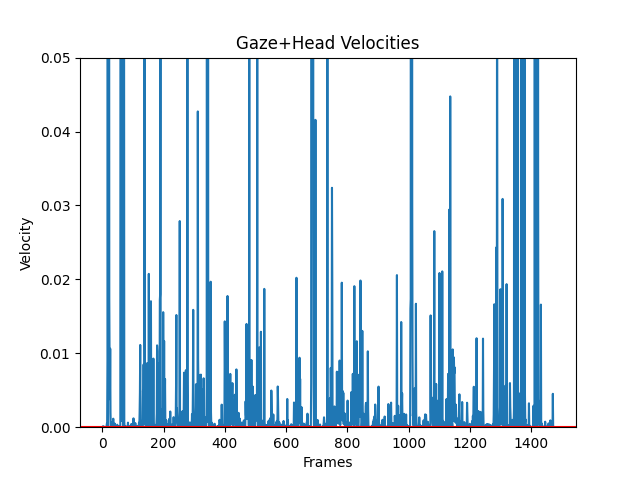

In [34]:
# both eyes
vel0 = EyeClassifier.preprocess(pdLGaze)
vel1 = EyeClassifier.preprocess(pdRGaze)

print(vel0)

model = EyeClassifier()
model.fit(eyes=(vel0, vel1))

labels, indiv_labels = model.predict(eyes=(vel0, vel1))
labels = labels[1::2]
label_both_np = labels["label"].to_numpy()
vel0_vals = vel0["velocity"].to_numpy()
labeled_gazehead_velocity = np.vstack((label_both_np, vel0_vals))
sorted_gazehead_vels = labeled_gazehead_velocity[:, labeled_gazehead_velocity[1].argsort()]
label_gazehead_diff = np.where(np.diff(sorted_gazehead_vels[0]) == 1)
boundary_gazehead_vel = sorted_gazehead_vels[1,label_gazehead_diff[0][0]]
print("Boundary velocity:",boundary_gazehead_vel)

plt.figure()
plt.plot(vel0["velocity"])
plt.axhline(boundary_gazehead_vel, color="r")
plt.title("Gaze+Head Velocities")
plt.xlabel("Frames")
plt.ylabel("Velocity")
plt.ylim(0,0.05)

In [35]:

# print(labels)
# 0- fix, 1- sac, -1 -> noise
labels_unique = labels[1::2]
labels_unique.index = np.arange(1, len(labels_unique) + 1) # start index from 1 instead of 0
labels_np = labels_unique.to_numpy()
print("labels_np.shape: ", labels_np.shape)
# add the labels to the original df:
#recdf_with_labels = df2.join(labels_unique["label"])

print("Num fixation total pts: ", np.sum(labels_np[:,2]))
print("Num saccades total pts: ", np.sum(labels_np[:,3]))
print("Num noise total pts: ", np.sum(labels_np[:,4]))
print()
# filter the consecutives
print("Num fixations: ", np.sum(np.diff(labels_np[:, 2]) == 1))
print("Num saccades: ", np.sum(np.diff(labels_np[:, 3]) == 1))
print("Num noise: ", np.sum(np.diff(labels_np[:, 4]) == 1))
#print("Num LightOns: ", num_targets_spawned)

labels_np.shape:  (737, 5)
Num fixation total pts:  724.0
Num saccades total pts:  13.0
Num noise total pts:  0.0

Num fixations:  11
Num saccades:  11
Num noise:  0


In [78]:
print(len(gazeOnlyFix))
print(len(bothgazeOnlyFix))

NameError: name 'gazeOnlyFix' is not defined

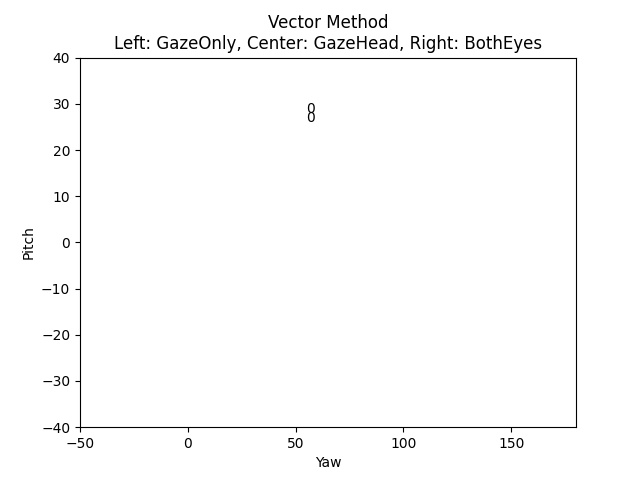

In [84]:
import matplotlib.pyplot as plt
import matplotlib.animation
import numpy as np
from collections import deque

start_frame = 30
end_frame = 1400
num_trace_points = 6

pitch = gazeOnlyPitch[start_frame:end_frame]
yaw = gazeOnlyYaw[start_frame:end_frame]

gh_pitch = gazeHeadPitch[start_frame:end_frame]
gh_yaw = gazeHeadYaw[start_frame:end_frame]

fig, ax = plt.subplots()
x, y = deque([]),deque([])
ghx, ghy = deque([]),deque([])
bothx, bothy = deque([]),deque([])
sc = ax.scatter(x,y,s=10)
plt.xlim(-50,180)
plt.ylim(-40,40)
plt.title("Vector Method\nLeft: GazeOnly, Center: GazeHead, Right: BothEyes")
plt.xlabel("Yaw")
plt.ylabel("Pitch")
time = ax.annotate(0, xy=(55, 28))
framenum = ax.annotate(0, xy=(55, 26))
# labdiff = ax.annotate(0, xy=(55, 22))
color = deque([])
ghcolor = deque([])
bothcolor = deque([])

def animate(i):
    x.append(yaw[i])
    y.append(pitch[i])
    ghx.append(gh_yaw[i]+60)
    ghy.append(gh_pitch[i]) 
    bothx.append(yaw[i]+120)
    bothy.append(pitch[i])
    
#     sc.set_offsets(np.r_[np.c_[x,y],np.c_[ghx,ghy]])
    sc.set_offsets(np.r_[np.c_[x,y],np.c_[ghx,ghy],np.c_[bothx,bothy]])
#     sc.set_offsets(np.r_[np.c_[x,y],np.c_[bothx,bothy]])
    
    if (gazeOnlyVecFix[i+start_frame] == 0):
        color.append("red")
    else:
        color.append("green")
    
    if (gazeHeadVecFix[i+start_frame] == 0):
        ghcolor.append("red")
    else:
        ghcolor.append("green")
        
    if (bothgazeOnlyFix[i+start_frame] == 0):
        bothcolor.append("red")
    else:
        bothcolor.append("green")
        
#     sc.set_color(np.r_[color,ghcolor])
    sc.set_color(np.r_[color,ghcolor,bothcolor])
#     sc.set_color(np.r_[color,bothcolor])
    
    time.set_text("Time: "+str(gazeOnlyTime[i+start_frame]))
    framenum.set_text("Frame: "+str(i+start_frame))
#     if (label_difference.iloc[i+start_frame]):
#         labdiff.set_text("gazeOnly:"+str(gazeOnlyLabel.iloc[i+start_frame]))
#     else:
#         labdiff.set_text("Label Diff:False")
        
    if (len(x) > num_trace_points):
        x.popleft()
    if (len(y) > num_trace_points):
        y.popleft()
    if (len(ghx) > num_trace_points):
        ghx.popleft()
    if (len(ghy) > num_trace_points):
        ghy.popleft()
    if (len(bothx) > num_trace_points):
        bothx.popleft()
    if (len(bothy) > num_trace_points):
        bothy.popleft()
    if (len(color) > num_trace_points):
        color.popleft()
    if (len(ghcolor) > num_trace_points):
        ghcolor.popleft()
    if (len(bothcolor) > num_trace_points):
        bothcolor.popleft()
    
        
ani = matplotlib.animation.FuncAnimation(fig, animate, 
                frames=end_frame - start_frame, interval=50, repeat=False) 
plt.show()

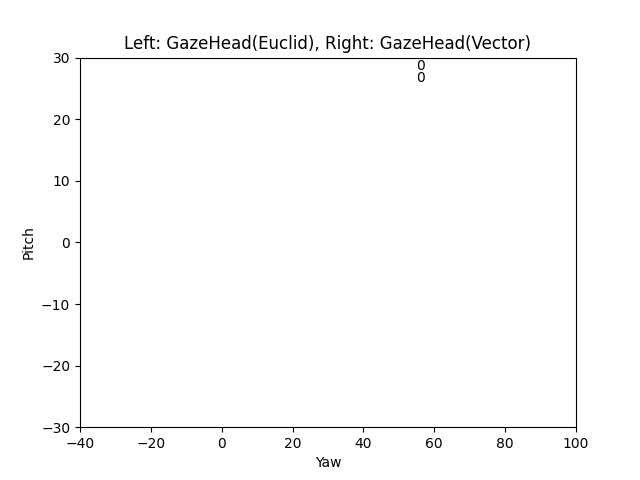

In [85]:
start_frame = 30
end_frame = 1400
num_trace_points = 6

pitch = gazeOnlyPitch[start_frame:end_frame]
yaw = gazeOnlyYaw[start_frame:end_frame]

gh_pitch = gazeHeadPitch[start_frame:end_frame]
gh_yaw = gazeHeadYaw[start_frame:end_frame]

fig, ax = plt.subplots()
x, y = deque([]),deque([])
ghx, ghy = deque([]),deque([])
sc = ax.scatter(x,y,s=10)
plt.xlim(-40,100)
plt.ylim(-30,30)
plt.title("Left: GazeHead(Euclid), Right: GazeHead(Vector)")
plt.xlabel("Yaw")
plt.ylabel("Pitch")
time = ax.annotate(0, xy=(55, 28))
framenum = ax.annotate(0, xy=(55, 26))
# labdiff = ax.annotate(0, xy=(55, 22))
color = deque([])
ghcolor = deque([])

def animate(i):
    x.append(gh_yaw[i])
    y.append(gh_pitch[i])
    ghx.append(gh_yaw[i]+60)
    ghy.append(gh_pitch[i]) 
    
    sc.set_offsets(np.r_[np.c_[x,y],np.c_[ghx,ghy]])
#     sc.set_offsets(np.r_[np.c_[x,y],np.c_[ghx,ghy],np.c_[bothx,bothy]])
#     sc.set_offsets(np.r_[np.c_[x,y],np.c_[bothx,bothy]])
    
    if (gazeHeadEucFix[i+start_frame] == 0):
        color.append("red")
    else:
        color.append("green")
    
    if (gazeHeadVecFix[i+start_frame] == 0):
        ghcolor.append("red")
    else:
        ghcolor.append("green")
        
    sc.set_color(np.r_[color,ghcolor])
#     sc.set_color(np.r_[color,ghcolor,bothcolor])
#     sc.set_color(np.r_[color,bothcolor])
    
    time.set_text("Time: "+str(gazeOnlyTime[i+start_frame]))
    framenum.set_text("Frame: "+str(i+start_frame))
#     if (label_difference.iloc[i+start_frame]):
#         labdiff.set_text("gazeOnly:"+str(gazeOnlyLabel.iloc[i+start_frame]))
#     else:
#         labdiff.set_text("Label Diff:False")
        
    if (len(x) > num_trace_points):
        x.popleft()
    if (len(y) > num_trace_points):
        y.popleft()
    if (len(ghx) > num_trace_points):
        ghx.popleft()
    if (len(ghy) > num_trace_points):
        ghy.popleft()
    if (len(color) > num_trace_points):
        color.popleft()
    if (len(ghcolor) > num_trace_points):
        ghcolor.popleft()
    
        
ani = matplotlib.animation.FuncAnimation(fig, animate, 
                frames=end_frame - start_frame, interval=20, repeat=False) 
plt.show()

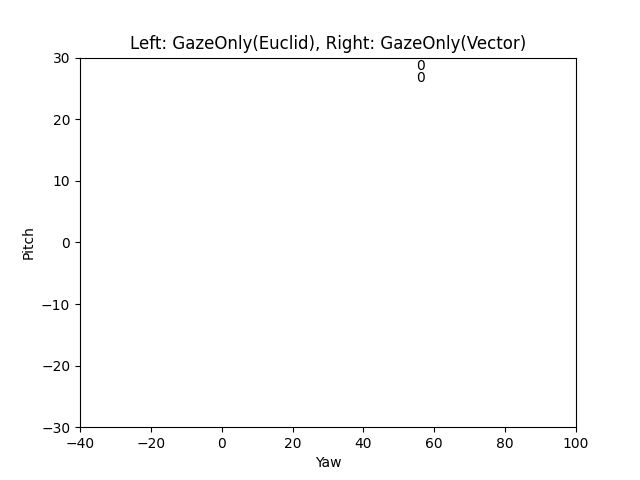

In [86]:
start_frame = 30
end_frame = 1400
num_trace_points = 6

pitch = gazeOnlyPitch[start_frame:end_frame]
yaw = gazeOnlyYaw[start_frame:end_frame]

gh_pitch = gazeHeadPitch[start_frame:end_frame]
gh_yaw = gazeHeadYaw[start_frame:end_frame]

fig, ax = plt.subplots()
x, y = deque([]),deque([])
ghx, ghy = deque([]),deque([])
sc = ax.scatter(x,y,s=10)
plt.xlim(-40,100)
plt.ylim(-30,30)
plt.title("Left: GazeOnly(Euclid), Right: GazeOnly(Vector)")
plt.xlabel("Yaw")
plt.ylabel("Pitch")
time = ax.annotate(0, xy=(55, 28))
framenum = ax.annotate(0, xy=(55, 26))
# labdiff = ax.annotate(0, xy=(55, 22))
color = deque([])
ghcolor = deque([])

def animate(i):
    x.append(yaw[i])
    y.append(pitch[i])
    ghx.append(yaw[i]+60)
    ghy.append(pitch[i]) 
    
    sc.set_offsets(np.r_[np.c_[x,y],np.c_[ghx,ghy]])
#     sc.set_offsets(np.r_[np.c_[x,y],np.c_[ghx,ghy],np.c_[bothx,bothy]])
#     sc.set_offsets(np.r_[np.c_[x,y],np.c_[bothx,bothy]])
    
    if (gazeOnlyEucFix[i+start_frame] == 0):
        color.append("red")
    else:
        color.append("green")
    
    if (gazeOnlyVecFix[i+start_frame] == 0):
        ghcolor.append("red")
    else:
        ghcolor.append("green")
        
    sc.set_color(np.r_[color,ghcolor])
#     sc.set_color(np.r_[color,ghcolor,bothcolor])
#     sc.set_color(np.r_[color,bothcolor])
    
    time.set_text("Time: "+str(gazeOnlyTime[i+start_frame]))
    framenum.set_text("Frame: "+str(i+start_frame))
#     if (label_difference.iloc[i+start_frame]):
#         labdiff.set_text("gazeOnly:"+str(gazeOnlyLabel.iloc[i+start_frame]))
#     else:
#         labdiff.set_text("Label Diff:False")
        
    if (len(x) > num_trace_points):
        x.popleft()
    if (len(y) > num_trace_points):
        y.popleft()
    if (len(ghx) > num_trace_points):
        ghx.popleft()
    if (len(ghy) > num_trace_points):
        ghy.popleft()
    if (len(color) > num_trace_points):
        color.popleft()
    if (len(ghcolor) > num_trace_points):
        ghcolor.popleft()
    
        
ani = matplotlib.animation.FuncAnimation(fig, animate, 
                frames=end_frame - start_frame, interval=200, repeat=False) 
plt.show()